## Lateral gene transfer shapes the distribution of RuBisCO among Candidate Phyla Radiation bacteria and DPANN archaea.

#### Supporting Material for Jaffe et al., 2018.

### Table of Contents:

<ul>
    1.    [Main RuBisCO analysis](#main-rubisco-analysis)<br>
    2.    [AMP Pathway analysis](#AMP-pathway-analysis)<br>
    3.    [PRK/Calvin Cycle analysis](#PRK/CBB-analysis)
</ul>

## Load in libraries and settings

In [1]:
import matplotlib, re, os, glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bio import SeqIO, SeqUtils
from matplotlib_venn import venn3
import seaborn as sns
import subprocess as sp
sns.set('notebook')
%matplotlib inline 
# adjust cell width
from IPython.core.display import display, HTML
from IPython.display import Image
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# MANUALLY SET WORKING DIRECTORY TO GIT REPOSITORY 
working_directory = ""

# main RuBisCO analysis

Here we perform the main phylogenetic analysis of the de-replicated RuBisCO sequences from across environments. <b> N.B. </b> This analysis draws on a number of previously generated files, available on the GitHub page linked to this publication.

First, we read in sequence headers from the de-replicated RuBisCO sequences. These headers contain the information needed for downstream analyses.

In [3]:
# read in headers
with open(os.path.join(working_directory, "data/drep99.headers")) as infile:
    headers = infile.readlines()
# remove duplicates
uniq = list(set(headers))

In [4]:
# how many unique sequences are there?
print(str(len(uniq)) + " sequences found.")

622 sequences found.


### read and process sequence headers

Sequences from external databases (NCBI, IMG, etc) have special metadata that we need to read in for accurate taxonomic assignment.

In [5]:
# IMG
with open(os.path.join(working_directory + "/data/scaffold_info/img_scaffold.info")) as img_in:
    lines = img_in.readlines()
# make into dictionary
img = {line.split("\t")[0]: {"tax": line.split("\t")[1], "bin":line.split("\t")[2].strip("\n")} for line in lines}

# NCBI
with open(os.path.join(working_directory + "/data/scaffold_info/ncbi_scaffold.info"))  as ncbi_in:
    lines2 = ncbi_in.readlines()
# make into dictionary
ncbi = {line.split("\t")[0]: {"tax":line.split("\t")[2].strip("\n"), "bin":line.split("\t")[2].strip("\n")} for line in lines2}

## TARA
with open(os.path.join(working_directory + "/data/scaffold_info/tara_scaffold.info"))  as tara_in:
    lines3 = tara_in.readlines()
# make into dictionary
tara = {line.split("\t")[1]: {"tax":line.split("\t")[2].strip("\n"), "bin": line.split("\t")[0]} for line in lines3}

## UBA
with open(os.path.join(working_directory + "/data/scaffold_info/uba_scaffold.info"))  as uba_in:
    lines4 = uba_in.readlines()
uba = {line.split("\t")[0]: {"tax":line.split("\t")[2].strip("\n"), "bin": line.split("\t")[0]} for line in lines4}

# merge dictionaries
scaffold_lookup = {**img, **ncbi, **tara, **uba}

Next, we define a function to parse sequence headers and extract the necessary metadata for use in a dataframe.

In [6]:
def parse_header(header):
    
    try:
        # for internal sequences
        m = re.search('^>(\S*).+?bin="([^"]*).+?taxon_class=(\S*).+?phylum=(\S*).+?organism_tax=(.*)$|organism_desc', header)
        return {"gene":m.group(1), "bin": m.group(2), "class": m.group(3), "phylum": m.group(4), "tax":m.group(5)}
    except:
        # for external sequences
        m = re.search('>([A-z0-9]+?)_([A-z0-9_.]+)_[0-9]+', header)
        try: 
            #control for variation in external headers
            if "UBA" not in header:
                tax = scaffold_lookup[m.group(2)]["tax"]
                bin = scaffold_lookup[m.group(2)]["bin"]
            else:
                tax = scaffold_lookup[m.group(1).replace("contig", "")]["tax"]
                bin = scaffold_lookup[m.group(1).replace("contig", "")]["bin"]
            return {"gene":m.group(0).split(" ")[0].strip(">"), "bin": "external " + bin, "class": "unknown", "phylum": "unknown", "tax":tax}
        except:
            try:
                # for phage sequences
                if "PHAGE" in header:
                    name = header.strip(">").strip("\n")
                    return {"gene": name, "bin": name, "class": "unknown", "phylum": "unknown", "tax":"putative_phage"}
            except: print(header)

In [7]:
# extract scaf, tax info
info = []
                
for header in uniq:
    info.append(parse_header(header))
    
# make into df
df = pd.DataFrame.from_dict(info)
df2 = df.dropna()

### assign taxonomy to sequences

In [9]:
# get phyla names
phyla = list(set(df2.phylum.values)) + ["Woesearchaeota","Patescibacteria","Gottesmanbacteria",\
                                        "Falkowbacteria", "Pacearchaeaota", "Pacearchaeota", "Aenigmarchaeota", \
                                        "Diapherotrites", "Nanoarchaeota", "Buchananbacteria","Veblenbacteria"]
# get rid of ambiguous taxonomies
phyla.remove("unknown")
phyla.remove("DPANN")

# read in tax override file into dict
with open(os.path.join(working_directory + "/data/tax_overrides.txt"))  as infile:
    lines = infile.readlines()
    
overrides = {}
for entry in lines:
    info = entry.strip().split("\t")
    overrides[info[0]] = info[1]

In [10]:
def assign_taxonomy(row):
    
    # phage sequences
    if row["tax"] == "putative_phage":
        return row["tax"]
    
    tax = "unknown"
    
    # if binned sequence
    if ("UNK" not in row["bin"]) and ("Unbinned" not in row["bin"]) and ("PHAGE" not in row["bin"]):
        
        if "external" in row["bin"]:
            field = "tax"
        else: field = "bin"
            
        for phylum in phyla:
            if phylum in row[field]:
                tax = phylum
        
        if tax == "WS6":
            tax = "Dojkabacteria"
        
        if tax == "Micraarchaeota":
            tax = "Micrarchaeota"
            
        #check tax override
        if row["bin"] in overrides:
            if overrides[row["bin"]] != "none":
                tax = overrides[row["bin"]]
            
    # if unbinned sequence
    if tax == "unknown":
        
        # phylum level
        if row["phylum"] in ["Peregrinibacteria", "Dojkabacteria","SR1","Micrarchaeota", "Pacearchaeota"]:
            tax = row["phylum"]

        elif row["phylum"] == "Micraarchaeota":
            tax = "Micrarchaeota"

        elif row["phylum"] == "WS6":
            tax = "Dojkabacteria"

        # class level
        elif row["phylum"] in ["Microgenomates","Parcubacteria","DPANN"]:
            if row["class"] == "Gottesmanbakteria":
                tax = "Gottesmanbacteria"
            elif row["class"] == "Pacearchaeaota":
                tax = "Pacearchaeota"
            elif row["class"] == "unknown":
                tax = row["phylum"]
            else: 
                tax = row["class"]
            
    return tax

In [11]:
# apply the taxonomy function
df2["final_tax"] = df2.apply(assign_taxonomy, axis=1)

### add in RuBisCO Form

Phylogenetic "Form" for sequences was determined as by constructing a maximum likelihood tree with RaXML (default parameters, cipres.org) and subsequently assigning each RuBisCO sequence to previously identified Forms based on phylogenetic clustering with reference sequences (Materials and Methods). Tree files are also available in the GitHub repository in /trees/.

In [12]:
# read in type file
types = pd.read_csv(os.path.join(working_directory + "/data/types.txt"), sep="\t", header=None)
types.columns = ["gene", "type"]
# update old names
types = types.replace(to_replace="III", value="III-b")
types = types.replace(to_replace="new", value="III-c")
types = types.replace(to_replace="II_III", value="II/III")
types = types.replace(to_replace="III_like", value="III-like")
types = types.replace(to_replace="IV_like", value="IV-like")

In [13]:
# join with tax table
data = pd.merge(df2, types)

### add in habitat/sample information

Next, we add some sample metadata describing the habitat from which genomes were recovered.

In [14]:
# read in habitat info and modify
metadata = pd.read_csv(os.path.join(working_directory + "/data/prefix_info.txt"), header=None, sep="\t")
md = metadata.fillna("None")
md.columns = ["prefix","sample","habitat","modifier"]

In [15]:
def prefixize(name):
    return name.split("_")[0]

In [16]:
# join tables
data["prefix"] = data["gene"].apply(lambda x: prefixize(x))
data2 = pd.merge(data, md, on="prefix", how="left")

### add amino acid residue information

To analyze the biochemically-relevant characteristics of the RuBisCO sequences included in the de-replicated set, including those in the putative phage category, we extracted 12 residues known to be important for catalytic activity and 7 important for substrate binding from each sequence (Tabita et al. J. Exp. Bot. 2008).  Alignment is available in the GitHub /alignments/.

We can then add these residues to the current data frame.

In [17]:
residues = {}
# read in extracted residue information from alignment
in_aln = SeqIO.parse(open(os.path.join(working_directory + "/alignments/rubisco_final_sites.aln")), "fasta")

# turn aln into dict
for record in in_aln:
    temp = {}
    temp["full_motif"] = str(record.seq)
    for i in range(0,len(record.seq)):
        temp[i] = str(record.seq)[i]
    residues[record.description] = temp

# cast as df
residues_df = pd.DataFrame.from_dict(residues, orient="index")
residues_df = residues_df.reset_index()
residues_df = residues_df[["index"] + list(range(0,19)) + ["full_motif"]]

# change col names
site_order = ["CA", "SB"] + ["CA"]*10 + ["SB"]*2 + ["CA"] + ["SB"]*4
sb, ca = 1, 1
col_names = ["gene"]
for site in site_order:
    if site=="CA":
        col_names.append("CA" + str(ca))
        ca+=1
    if site=="SB":
        col_names.append("SB" + str(sb))
        sb+=1
col_names.append("full_motif")
residues_df.columns = col_names

In [18]:
# merge the data tables
data3 = pd.merge(data2, residues_df, on="gene")
final = data3

### sanity check - any lost sequences?

In [19]:
len(final)

622

Let's have a look at our dataframe.

In [20]:
final[final.type=="III-c"]["final_tax"].value_counts()

Parcubacteria        15
Gottesmanbacteria    12
Kuenenbacteria       10
Falkowbacteria        4
Patescibacteria       3
Microgenomates        1
unknown               1
Dojkabacteria         1
Name: final_tax, dtype: int64

### add info back to the alignment

In [21]:
# create dict keyed by gene - internal
info_dict = {}
for index,row in data3.iterrows():
    info_dict[row["gene"]] = {"tax":row["final_tax"], "type": row["type"]}
    
#ref sequences
for line in open(os.path.join(working_directory + "data/ref_types.txt")).readlines():
    if "_REF" in line:
        info = line.strip().split("\t")
        info_dict[info[0]] = {"tax":"reference", "type": info[1]}

In [25]:
# read in alignment
with open(os.path.join(working_directory + "alignments/rubisco_final.drep99.wrefs.named.aln"), "w") as new_aln:

    aln = working_directory + "alignments/rubisco_final.drep99.wrefs.aln"
        
    for record in SeqIO.parse(open(aln),"fasta"):
        # prune names
        m = re.search("(\S+).*", record.description)
        # add sequence to dict
        try: info_dict[m.group(1)]["seq"] = str(record.seq)
        except: print(record.description)

    #sort by type and tax
    seq_df = pd.DataFrame.from_dict(info_dict, orient="index")
    seq_df.sort_values(["type", "tax"], inplace=True)

    for index, row in seq_df.iterrows():
        new_header = index + ":" + row["tax"] + ":" + row["type"]
        new_aln.write(">" + str(new_header) + "\n" + str(row["seq"]) + "\n")

### figure 1 - sequence logos by RuBisCO Form

Next, we can generate the sequence logos that accompany the phylogenetic tree and protein models in Fig. 1.

In [26]:
os.mkdir(os.path.join(working_directory + "/images/"))

In [27]:
def make_logo(df, slug, title):
    
    # dataframe -> alignment
    with open(working_directory + "/images/temp.aln", "w") as outfile:
        for index, row in df.iterrows():
            outfile.write(">" + row["gene"] + "\n" + row["full_motif"] + "\n")
    # get site names
    site_names = list(df.columns[11:30])
    ticks = ",".join(site_names)
    
    # run weblogo
    command = "weblogo -f " + working_directory + "/images/temp.aln -o " + working_directory + "/images/" + slug + ".eps" + " -F 'eps' --show-xaxis NO --annotate " + ticks + " --rotate-numbers True -s large --fineprint '' -c chemistry -t '" + title + "'"
    sp.call(command, shell=True)
    # remove alignment
    os.remove(working_directory + "/images/temp.aln")

In [28]:
final[final["final_tax"]!="unknown"]["type"].value_counts()

III-b       326
III-like     89
IV-like      84
III-c        46
II/III       44
unknown      11
IV            9
Name: type, dtype: int64

In [29]:
# now generate a logo for each type
for rubisco_type in set(data3.type):
    
    if rubisco_type not in ["unknown", "II"]:
        
        # don't use tax == unknown for this, bc specifying cpr/dpann/phage
        subset = data3[(data3.type == rubisco_type) & (data3.final_tax != "unknown")]
        
        # deal with naming issues
        if rubisco_type == "II/III":
            rubisco_type_final = "II_III"
        else: rubisco_type_final = rubisco_type
        
        title = "%s, n=%d" %(rubisco_type, len(subset))
        make_logo(subset, rubisco_type_final, title)

### figure 2 - RuBisCO distribution among the CPR/DPANN

To create Figure 2, we need to assemble a number of different statistics.

In [30]:
# define which phyla we want in the figure
tokeep = ["Aenigmarchaeota","Beckwithbacteria","Dojkabacteria","Djokabacteria","Diapherotrites",\
          "Falkowbacteria","Gottesmanbacteria","Kuenenbacteria","Micrarchaeota","Pacearchaeota", \
          "Pacearchaeaota","Parcubacteria","Peregrinibacteria","Roizmanbacteria","SR1","Woesearchaeota","WS6"]

# define function to extract taxonomy for non-redundant genomes
def get_bin_tax(row):
    
    final_tax = "none"
    
    # start checking tax string
    for item in tokeep:
        if item in row["taxonomy"]:
            final_tax = item
    
    # if nothing found, check bin name
    for item in tokeep:
        if item in row["name"]:
            final_tax = item
    
    if final_tax == "Pacearchaeaota":
        final_tax = "Pacearchaeota"
    
    if (final_tax == "WS6") or (final_tax == "Djokabacteria"):
        final_tax = "Dojkabacteria"
    
    return final_tax

#### first, the fraction of non-redundant genomes w/ RuBisCO

To quantitatively assess RuBisCO presence across CPR and DPANN phyla, we repeated the KEGG analysis described in the methods for a set of ~3000 high quality genomes from various environments. These genomes were de-replicated at 99% secondary ANI using dRep (-comp 20) (Olm et al. ISME J. 2017) and then analyzed for presence of RuBisCO. We can read in the results of that analysis here...

In [31]:
# read in names of all bins analyzed
kegg_bins = pd.read_csv(os.path.join(working_directory + "/data/kegg_analysis/kegg_bins.txt"), sep="\t",header=None)
kegg_bins.columns = ["name"]
# add taxonmy information
tax_table = pd.read_csv(os.path.join(working_directory + "/data/kegg_analysis/all_organism_tax.table"), sep = "\t")
temp = pd.merge(kegg_bins, tax_table, on="name", how="left")
# now add rubisco-containing bins
kegg_rubiscos = pd.read_csv(os.path.join(working_directory + "/data/kegg_analysis/kegg_bins_wrubisco.txt"), sep ="\t", header=None)
kegg_rubiscos["ones"] = 1
kegg_rubiscos.columns = ["name", "ones"]
# merge this info in
all_genome_info = pd.merge(temp, kegg_rubiscos, on="name", how='left')
all_genome_info["ones"] = all_genome_info["ones"].fillna(0)
# get final taxonomy for bins
all_genome_info["taxonomy"] = all_genome_info["taxonomy"].fillna("None")
all_genome_info["final_tax"] = all_genome_info.apply(get_bin_tax, axis=1)
# get total number of genomes from each tax group
all_genome_info["total_ones"] = 1
all_genome_info_subset = all_genome_info[["final_tax","ones","total_ones"]]
all_g = all_genome_info_subset.groupby("final_tax", as_index=False).sum()
# remove some things we don't want
to_remove = ["Parcubacteria","Microgenomates","none"]
all_g = all_g[~all_g.final_tax.isin(to_remove)]
# display proportion of genomes with RuBisCO
all_g["Fraction of N.R.G. w/ RuBisCO"] = all_g.apply(func=lambda x: str(int(x["ones"])) + "/" + str(int(x["total_ones"])), axis=1)

In [32]:
all_g.head()

,final_tax,ones,total_ones,Fraction of N.R.G. w/ RuBisCO
0,Aenigmarchaeota,4.0,8,4/8
1,Beckwithbacteria,1.0,11,1/11
2,Diapherotrites,8.0,12,8/12
3,Dojkabacteria,8.0,9,8/9
4,Falkowbacteria,0.0,21,0/21


#### counts of unbinned + binned genes

In the main analysis, how many of the analyzed RuBisCO genes are from binned/unbinned genomes, respectively?

In [33]:
# these genomes are technically binned, but bins are low completeness/ quality so treating them as unbinned here
with open(os.path.join(working_directory + "/data/internal_unbinned.names")) as infile:
    lines = infile.readlines()
internal_unbinned = [item.strip() for item in lines]

In [34]:
# now get stats for binned vs unbinned rubisco
types = {}
for index, row in final.iterrows():
    # if binned
    if ("UNK" not in row["bin"]) and ("Unbinned" not in row["bin"]) and ("PHAGE" not in row["bin"]) and (row["gene"] not in internal_unbinned):
        if row["final_tax"] not in types:
            types[row["final_tax"]] = {"binned":1, "unbinned":0}
        else: types[row["final_tax"]]["binned"] += 1
    # if unbinned
    else:
        if row["final_tax"] not in types:
            types[row["final_tax"]] = {"binned":0, "unbinned":1}
        else: types[row["final_tax"]]["unbinned"] += 1

In [35]:
# reformat type results
types_df = pd.DataFrame.from_dict(types, orient="index")
types_df2 = types_df.reset_index()
types_df2.columns = ["organism_taxonomy", "Binned Sequences","Unbinned Sequences"]
# merge this with results of NRG analysis, rename
types_df2 = pd.merge(types_df2, all_g, left_on="organism_taxonomy", right_on="final_tax", how="left")
types_df2 = types_df2[["organism_taxonomy","Unbinned Sequences","Binned Sequences","Fraction of N.R.G. w/ RuBisCO"]]

#### counts by RuBisCO Form

In [36]:
form_sub = data2[["final_tax","type","gene"]]
form_sub_g = form_sub.groupby(["final_tax","type"], as_index=False).count()
form_sub_g.columns = ["organism_taxonomy","rubisco_type","count"]
form_sub_p = form_sub_g.pivot("organism_taxonomy", "rubisco_type", "count")
# fill na with 0
form_sub_p = form_sub_p.fillna(0)
# convert to int counts
form_sub_p["organism_taxonomy"] = form_sub_p.index
test = form_sub_p.drop("organism_taxonomy", axis=1)
fsp_int = test.astype(int)

#### counts by habitat

In [37]:
hab_sub = data2[["final_tax","habitat","gene"]]
hab_sub_g = hab_sub.groupby(["final_tax","habitat"], as_index=False).count()
hab_sub_g.columns = ["organism_taxonomy","habitat","count"]
hab_sub_p = hab_sub_g.pivot("organism_taxonomy", "habitat", "count")
# fill na with 0
hab_sub_p = hab_sub_p.fillna(0)
# convert to int counts
hab_sub_p["organism_taxonomy"] = hab_sub_p.index
hab_sub_p = hab_sub_p.drop("organism_taxonomy", axis=1)
hsg_int = hab_sub_p.astype(int)

#### combine and plot

In [38]:
temp_merge = pd.merge(types_df2, fsp_int, on="organism_taxonomy")
merged = pd.merge(temp_merge, hsg_int, on="organism_taxonomy")
# remove some rows/cols with low counts
toremove = ["II","unknown","Animal","Fermentation","None","Palm Oil Mill Effluent","Water"]
merge_mod = merged[(merged["organism_taxonomy"].isin(tokeep))]
merge_mod = merge_mod.replace("Parcubacteria","Other Parcubacteria")
mt_reindex = merge_mod.set_index("organism_taxonomy")
merge_trimmed = mt_reindex[list(mt_reindex.columns[~mt_reindex.columns.isin(toremove)])]
merge_ordered = merge_trimmed.reindex(["Aenigmarchaeota","Diapherotrites","Micrarchaeota","Pacearchaeota","Woesearchaeota","Dojkabacteria","Peregrinibacteria","SR1","Beckwithbacteria","Gottesmanbacteria","Roizmanbacteria","Falkowbacteria","Kuenenbacteria","Other Parcubacteria"])
merge_binary = merge_ordered >= 1

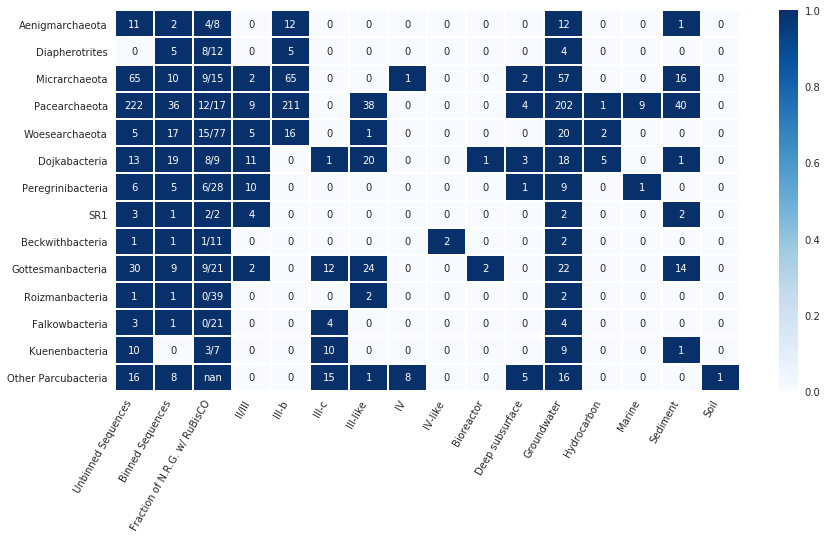

In [39]:
plt.figure(figsize=(14,7))
sns.heatmap(merge_binary, annot=merge_ordered, fmt='', linewidths=1, cmap="Blues")
plt.xticks(rotation=60, ha="right")
plt.ylabel("")
plt.savefig(os.path.join(working_directory + "/images/fig_2.svg"), format="svg")

### examining some interesting facets of RuBisCO distribution

#### Form III-b RuBisCO

In [40]:
# separate out arc/bac components
arc = final[(final["final_tax"].str.contains("archae")) | (final["final_tax"].str.contains("Diaphero"))]
bac = final[(~final["final_tax"].str.contains("archae")) & (~final["final_tax"].str.contains("Diaphero")) & (final["final_tax"] != "unknown")]

In [41]:
bac[bac.type=="III-b"].final_tax.value_counts()

Amesbacteria        10
Levybacteria         3
CPR                  1
Buchananbacteria     1
Name: final_tax, dtype: int64

Some sequences from CPR appear to encode Form III-b archaeal RuBisCO. As noted in the manuscript, further analysis showed that taxonomic profiling for these bins was inconclusive in the case of Amesbacteria, Levybacteria, and Kuenenbacteria, and incorrect in the case of Buchananbacteria.

In [42]:
arc[arc.type=="III-b"].final_tax.value_counts()

Pacearchaeota      211
Micrarchaeota       65
Woesearchaeota      16
Aenigmarchaeota     12
Diapherotrites       5
Nanoarchaeota        2
Name: final_tax, dtype: int64

We add III-b sequences from Diapherotrites, Micrarchaeota, and Woesearchaeota.

### type IV + IV-like

In [43]:
final[final.type=="IV"].final_tax.value_counts()

Parcubacteria    8
unknown          1
Micrarchaeota    1
Name: final_tax, dtype: int64

In [44]:
final[final.type=="IV-like"].final_tax.value_counts()

putative_phage      82
Beckwithbacteria     2
unknown              1
Name: final_tax, dtype: int64

Interestingly, all Beckwithbacteria in our dataset have type IV RLPs.

### Form III-c

In [45]:
final[final.type=="III-c"].final_tax.value_counts()

Parcubacteria        15
Gottesmanbacteria    12
Kuenenbacteria       10
Falkowbacteria        4
Patescibacteria       3
Microgenomates        1
unknown               1
Dojkabacteria         1
Name: final_tax, dtype: int64

This is a very interesting group! Gottesmanbacteria are split between here and III-like, whereas Kuenenbacteria and Falkowbacteria are almost exclusively in this clade.

# AMP pathway analysis

<ul>
    1.    [Main RuBisCO analysis](#main-rubisco-analysis)<br>
    2.    [AMP Pathway analysis](#AMP-pathway-analysis)<br>
    3.    [PRK/Calvin Cycle analysis](#PRK/CBB-analysis)
</ul>

For this part of the analysis, we'll focus on binned genomes.

### regenerate data for binned genomes

First, we need to regenerate a dataframe for all the binned RuBisCO sequences, as many were 'de-replicated out' of the first analysis and therefore not included.

In [46]:
# read in sequences from binned genomes
file_in = SeqIO.parse(open(os.path.join(working_directory + "/data/rubisco_binned.final.min200.faa")), "fasta")

# gather headers
headers = []
for record in file_in:
    headers.append(">" + record.description)

# parse headers
genomes = []
for header in headers:
    genomes.append(parse_header(header))

# re-assign taxonomy"
df = pd.DataFrame.from_dict(genomes)
binned = df.dropna()
binned["final_tax"] = binned.apply(assign_taxonomy, axis=1)

Binned sequences excluded from the de-replicated set were re-inserted into the tree and classified for downstream analyses. We add those back in here.

In [47]:
# add rubisco type
types = pd.read_csv(os.path.join(working_directory + "/data/types_binned.txt"), sep="\t", header=None)
types.columns = ["gene", "type"]
# clean type names
types = types.replace(to_replace="III", value="III-b")
types = types.replace(to_replace="new", value="III-c")
types = types.replace(to_replace="II_III", value="II/III")
types = types.replace(to_replace="III_like", value="III-like")
binned2 = pd.merge(binned,types, how="left")
# add habitat
binned2["prefix"] = binned2["gene"].apply(lambda x: prefixize(x))
binned3 = pd.merge(binned2, md, how = "left", on="prefix")

In [48]:
# clean up project name
def reassign_sample(row):
    if "external" in row["bin"]: 
        if "img" in row["gene"]:
            return "IMG"
        elif "NCBI" in row["gene"]:
            return "NCBI"
        elif "UBA" in row["gene"]:
            return "UBA"
        elif "tara" in row["gene"]:
            return "TARA"
    else: return row["sample"]
    
binned3["project"] = binned3.apply(reassign_sample, axis=1)

What's the distribution of RuBisCO types among high-quality binned genomes?

In [49]:
binned3.type.value_counts()

III-b       106
III-like     74
II/III       68
III-c        59
unknown      10
IV            4
IV_like       1
Name: type, dtype: int64

Now, we want to analyze the rest of the AMP pathway among these binned genomes. First step is to add in information about these pathway components from the KEGG analysis (see materials and methods).

### add <i>e2b2</i> and <i>deoA</i> results

In [50]:
# define function to clean kegg hmm results
def repair(list_set):
    for item in list_set:
        if item["bin"] == "-":
            m = re.search("[A-z]+_([A-z0-9.]+)_[0-9]+", item["gene"])
            item["bin"] = scaffold_lookup[m.group(1)]["bin"]

In [51]:
# read in kegg hmm results
e2b2_info, deo_info = [], []

for line in open(os.path.join(working_directory + "/data/kegg_analysis/e2b2.results")):
    e2b2_info.append({"bin":line.split("\t")[0].strip("\n"), "gene":line.split("\t")[1].strip("\n")})
for line in open(os.path.join(working_directory + "/data/kegg_analysis/deo.results")):
    deo_info.append({"bin":line.split("\t")[0].strip("\n"), "gene":line.split("\t")[1].strip("\n")})

repair(e2b2_info)
repair(deo_info)

In [52]:
# create df's 
e2b2_df = pd.DataFrame.from_dict(e2b2_info)
deo_df = pd.DataFrame.from_dict(deo_info)
e2b2_df.columns = ["bin2", "e2b2_gene"]
deo_df.columns =  ["bin2", "deoA_gene"]
# join dfs
# NB needed for kegg hmm import strategy
binned3["bin2"] = binned3.bin.str.replace("external ", "")
temp = pd.merge(binned3, deo_df, how="left", on="bin2")
nsp = pd.merge(temp, e2b2_df, how = "left", on="bin2").fillna("None")
# remove duplicates
nsp = nsp.drop_duplicates()

Now we have a dataframe connecting genomes, their RuBisCO gene, and deoA and e2b2 genes if they have them. Next, we analyze patterns of co-occurence, ordering, and proximity of the pathway among these genomes.

### analyze co-occurence of AMP pathway genes among binned genomes

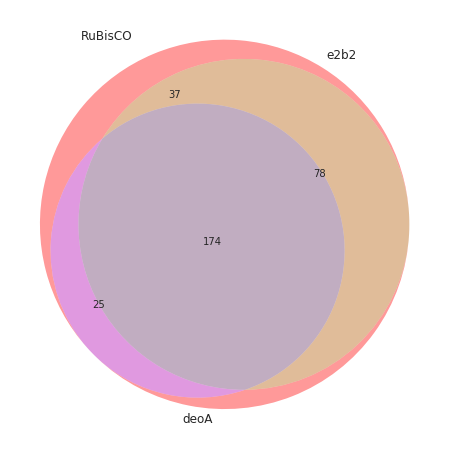

In [53]:
def venn_it(df):
    # ones with rubisco
    set1 = set(df["bin"])
    # ones with e2b2
    set2 = set(list(df[df["e2b2_gene"] != "None"]["bin"]))
    # ones with deoA
    set3 = set(list(df[df["deoA_gene"] != "None"]["bin"]))

    plt.figure(figsize=(8,8))
    venn3([set1,set2,set3], ("RuBisCO", "e2b2", "deoA"))
    #plt.show()
    plt.savefig(os.path.join(working_directory + "/images/fig_S2a.svg"), format="svg")

venn_it(nsp)

On a first pass, we see that many genomes contain only RuBisCO and e2b2, without deoA.

In [54]:
nsp[nsp.final_tax=="Gottesmanbacteria"]["deoA_gene"].value_counts()

None                                       47
RBG_16_OP11_37_8_RBG_16_scaffold_649_41     1
Name: deoA_gene, dtype: int64

Additionally, see that almost no Gottesmanbacteria contain a deoA gene as currently analyzed. Looking more closely, we found that most Gottesmanbacteria (OP11) contained homologs to deoA at a threshold lower than originally used in the KEGG analysis, as these sequences generally had a conserved deletion of ~80 amino acids at the start of the protein compared to other CPR proteins. Despite this, we predict that these proteins are divergent deoA homologs based on phylogenetic placement and re-alignment with reference sequences. So, we separately extracted them and can add them back to the dataframe:

### add in data for divergent Gottesmanbacteria <i> deoA </i> - Figure S2a

In [55]:
# read in scaffold 2 bin information
scaf2bin = {}
for line in open(os.path.join(working_directory + "/data/kegg_analysis/all.scaf2bin")):
    scaf2bin[line.split("\t")[0]] = line.split("\t")[1].strip("\n")
    
# def useful function to extract scaffold name
def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

In [56]:
# read in divergent gottesman deoA and clean
gottes = pd.read_csv(os.path.join(working_directory + "/data/kegg_analysis/gottes.tbl"), sep="\t", header=None)
gottes.columns = ["deoA_gene", "annot", "eval","score"]
gottes["scaf"] = gottes["deoA_gene"].apply(scaffold)
gottes["bin2"] = gottes["scaf"].apply(lambda x: scaf2bin[x])
# filter for only quality hits using hmm score
gottes_subset = gottes[(gottes["score"]>100)][["bin2", "deoA_gene"]]
nsp["bin2"] = nsp.bin.str.replace("external ", "")
# merge with old data
nsp_g = pd.merge(nsp, gottes_subset, on="bin2", how="left").fillna("None")

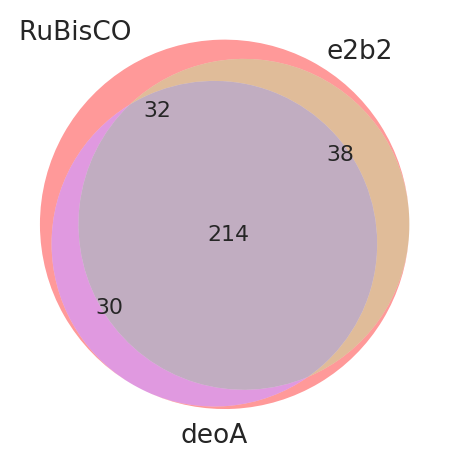

In [57]:
# update dataframe and plot
def choose(row):
    return row["deoA_gene_x"] if row["deoA_gene_x"] != "None" else row["deoA_gene_y"]

nsp_g["deoA_gene"] = nsp_g.apply(choose, axis=1)
matplotlib.rcParams.update({'font.size': 22})
nsp_new = nsp_g
venn_it(nsp_new)

In [58]:
# percentage of Gottesman bacteria encoding divergent deoA
len(set(nsp_new[(nsp_new.final_tax=="Gottesmanbacteria") & (nsp_new.deoA_gene!="None")]["bin"]))/float(len(set(nsp_new[(nsp_new.final_tax=="Gottesmanbacteria")]["bin"])))

0.9148936170212766

### how many binned genes have all pathway components on the same contig? Figure S2b

In [59]:
rub_scafs = [scaffold(gene) for gene in list(nsp_new.gene)]
e2b2_scafs = [scaffold(gene) for gene in list(nsp_new["e2b2_gene"])]
deo_scafs = [scaffold(gene) for gene in list(nsp_new["deoA_gene"])]

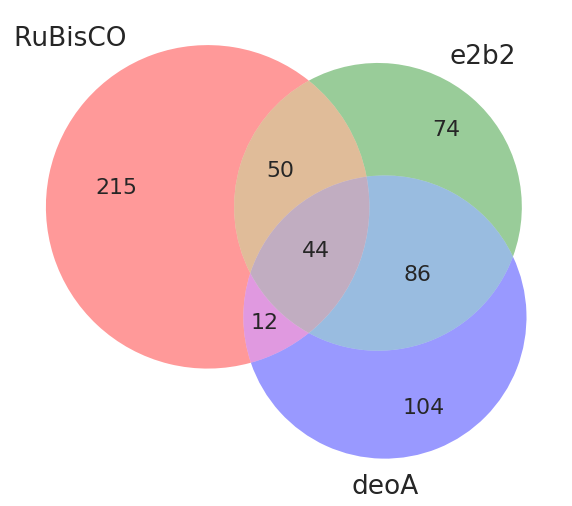

In [60]:
plt.figure(figsize=(10,10))
venn3([set(rub_scafs),set(e2b2_scafs),set(deo_scafs)], ("RuBisCO", "e2b2", "deoA"))
#plt.show()
plt.savefig(os.path.join(working_directory + "/images/fig_S2b.svg"), format="svg")

There are 46 fragments encoding all three genes of the AMP pathway. For those, we can then analyze gene order and proximity...

### analyze gene order for all genomes - Figure S2c

In [61]:
# function to count genes on the same scaffold
def scaffoldize(row):
    
    scaffolds = []
    for gene in genes:
        
        if row[gene] != "None":
            scaffolds.append(re.search("(.+?)_[0-9]+$", row[gene]).group(1))
        else:
            scaffolds.append("None_" + gene)
    
    return  (len(genes)+1) - len(set(scaffolds))    

# if so, gets order of genes
def get_gene_order(row):
    
    if row["proximity"] == 3:
        
        gene_nos = []

        # get gene numbers as ints
        for gene in genes:
            if row[gene] != "None":
                gene_nos.append(int(row[gene].split("_")[-1]))

        # test for consecutiveness
        if ((max(gene_nos) - min(gene_nos)) == (len(gene_nos) -1)) & (len(gene_nos) > 1):
            is_consecutive = True
        else: is_consecutive = False
            
        # sort gene numbers
        gene_nos_sorted = sorted(gene_nos)
        
        # get gene ordering
        order = ["slot"]*3
        for gene in genes:
            order[gene_nos_sorted.index(int(row[gene].split("_")[-1]))] = gene
        
        # rename rubisco
        order_mod = [gene if gene != "gene" else "rubisco" for gene in order]
        # control for fusions
        order_mod2 = [gene if gene != "slot" else "rubisco" for gene in order_mod]
        
        return ", ".join(order_mod2), is_consecutive
             
    else: return "n/a", "n/a"

# checks if genes are the same - fusion candidates
def is_fusion(row):
    
    # get genes which are not None
    genes = [row["gene"], row["e2b2_gene"], row["deoA_gene"]]
    not_none = [gene for gene in genes if gene != "None"]
    
    # if any are the same
    if len(set(not_none)) < len(not_none):
        
        return True
    
    else: return False

In [62]:
# apply these functions to the dataframe
genes = ["gene", "e2b2_gene", "deoA_gene"]
nsp_new["proximity"] = nsp_new.apply(scaffoldize, axis=1)
nsp_new["order"], nsp_new["is_consecutive"] = zip(*nsp_new.apply(get_gene_order, axis=1))
nsp_new["is_fusion"] = nsp_new.apply(is_fusion, axis =1 )

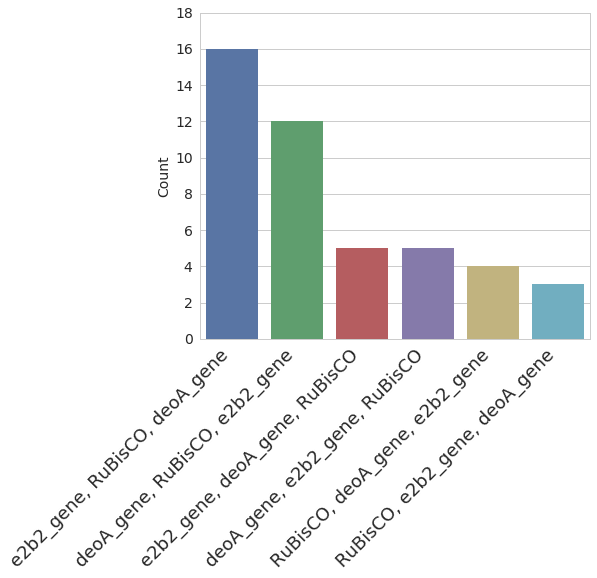

In [63]:
# plot / analyze order of genes in cases where we have all three!
x = nsp_new[nsp_new.proximity ==3].drop_duplicates()["order"].str.replace("rubisco","RuBisCO").value_counts()
sns.set_style("whitegrid")
xy = pd.DataFrame(x)
xy["type"] = xy.index
plt.figure(figsize=(7,6))
sns.barplot(x="type", y="order", data=xy)
plt.xticks(rotation=45, ha="right", fontsize=18)
plt.yticks(fontsize=14)
plt.xlabel("")
plt.ylabel("Count", fontsize=14)
plt.yticks(np.arange(0, 20, 2.0))
plt.savefig(os.path.join(working_directory + "/images/fig_S2c.svg"), format="svg")

Most genomes with the AMP pathway components on the same contig have RuBisCO in the middle.

In [64]:
nsp_new[nsp_new["is_consecutive"] == True]["order"].value_counts()

deoA_gene, rubisco, e2b2_gene    6
e2b2_gene, rubisco, deoA_gene    5
Name: order, dtype: int64

Among genomes with consecutive pathways, all have RuBisCO in the middle. At this point, we can also examine which contigs encoded all three genes consecutively:

In [65]:
nsp_new[nsp_new.is_consecutive==True][["bin","final_tax","deoA_gene", "gene","e2b2_gene"]]

,bin,final_tax,deoA_gene,gene,e2b2_gene
5,GWA2_OD1_42_15,Kuenenbacteria,gwa2_scaffold_11482_4,gwa2_scaffold_11482_5,gwa2_scaffold_11482_6
35,GWC2_OD1_39_14,Parcubacteria,gwc2_scaffold_633_22,gwc2_scaffold_633_23,gwc2_scaffold_633_24
39,GWA2_OD1_40_23,Parcubacteria,gwa2_scaffold_913_22,gwa2_scaffold_913_23,gwa2_scaffold_913_24
177,Candidatus Kuenenbacteria bacterium RIFCSPHIGH...,Kuenenbacteria,RIFCSPHIGHO2_02_FULL_OD1_42_29_rifcsphigho2_02...,RIFCSPHIGHO2_02_FULL_OD1_42_29_rifcsphigho2_02...,RIFCSPHIGHO2_02_FULL_OD1_42_29_rifcsphigho2_02...
187,Candidatus Kuenenbacteria bacterium RIFCSPHIGH...,Kuenenbacteria,RIFCSPHIGHO2_12_FULL_OD1_42_14_rifcsphigho2_12...,RIFCSPHIGHO2_12_FULL_OD1_42_14_rifcsphigho2_12...,RIFCSPHIGHO2_12_FULL_OD1_42_14_rifcsphigho2_12...
203,Candidatus Kuenenbacteria bacterium RIFCSPLOWO...,Kuenenbacteria,RIFCSPLOWO2_02_FULL_OD1_42_16_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OD1_42_16_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OD1_42_16_rifcsplowo2_02_s...
215,Candidatus Kuenenbacteria bacterium RIFCSPLOWO...,Kuenenbacteria,RIFCSPLOWO2_12_FULL_OD1_42_13_rifcsplowo2_12_s...,RIFCSPLOWO2_12_FULL_OD1_42_13_rifcsplowo2_12_s...,RIFCSPLOWO2_12_FULL_OD1_42_13_rifcsplowo2_12_s...
238,CG1_02_FULL_Parcubacteria_OD1_37_51_curated,Parcubacteria,cg1_0.2_scaffold_3774_c_6,cg1_0.2_scaffold_3774_c_7,cg1_0.2_scaffold_3774_c_8
251,CG2_30_FULL_CPR_37_22_curated,unknown,cg2_3.0_scaffold_3725_c_6,cg2_3.0_scaffold_3725_c_7,cg2_3.0_scaffold_3725_c_8
379,external UBA1441,Patescibacteria,UBA1441contig_19953_12,UBA1441contig_19953_11,UBA1441contig_19953_10


### finally, examine genomic proximity

To examine genomic proximity among pathway components on the same contig, we generated 'gene reports' describing the start position, end position, and strand for the RuBisCO, e2b2, and deoA genes being analyzed. The proximity of the genes on the same contig was calculated by taking the sum the lengths of the intervals between the genes (Methods).

In [66]:
# function to process gene reports
def process_gene_report(file):
    
    temp_dict = {}
    
    with open(file) as infile:
        lines = infile.readlines()

    for line in lines:
        if "No feature found" not in line:
            s = line.strip().split("\t")
            temp_dict[s[0]] = {"start": s[1], "end":s[2], "strand":s[3]}
            
    df = pd.DataFrame.from_dict(temp_dict, orient="index")
    
    return df.reset_index()

# function to get distance between components
def get_cluster_tightness(row):
    
    # shorthand
    d = {"e2b2_gene": "e2b2", "rubisco": "rub", "deoA_gene": "deo"}
    
    if (row["order"] != "n/a") and (row["rub_start"] != "None"):
        # first define gene positions
        first, second, third = row["order"].split(", ")[0:3]
        
        interval_one = int(row[d[second] + "_start"]) - int(row[d[first] + "_end"])
        interval_two = int(row[d[third] + "_start"]) - int(row[d[second] + "_end"])
        
        return float(interval_one + interval_two)
        
    else: return "n/a"

In [67]:
# read in data for internal genomes
rub_in = process_gene_report(os.path.join(working_directory + "/data/gene_reports/RUB.internal.report"))
# external genomes
rub_ex = process_gene_report(os.path.join(working_directory + "/data/gene_reports/RUB.external.report"))
rub = pd.concat([rub_in, rub_ex])
rub.columns = ["gene"] + [("rub_" + item) for item in list(rub_in.columns[1:])]

deo_in = process_gene_report(os.path.join(working_directory + "/data/gene_reports/DEO.internal.report"))
deo_ex = process_gene_report(os.path.join(working_directory + "/data/gene_reports/DEO.external.report"))
deo = pd.concat([deo_in, deo_ex])
deo.columns = ["deoA_gene"] + [("deo_" + item) for item in list(rub_in.columns[1:])]

e2b2_in = process_gene_report(os.path.join(working_directory + "/data/gene_reports/E2B2.internal.report"))
e2b2_ex = process_gene_report(os.path.join(working_directory + "/data/gene_reports/E2B2.external.report"))
e2b2 = pd.concat([e2b2_in, e2b2_ex])
e2b2.columns = ["e2b2_gene"] + [("e2b2_" + item) for item in list(rub_in.columns[1:])]

# merge these data with existing df
temp1 = pd.merge(nsp_new, rub, on="gene", how="left")
temp2 = pd.merge(temp1, deo, on="deoA_gene", how="left")
temp3 = pd.merge(temp2, e2b2, on="e2b2_gene", how="left")
nsp_final = temp3.fillna("None").drop_duplicates()
# apply the function
nsp_final["tightness"] = nsp_final.apply(get_cluster_tightness, axis=1)

Plot distribution of pathway tightness/proximity.

In [ ]:
nsp_temp = nsp_final[nsp_final.tightness != "n/a"]
plt.figure(figsize=(10,3))
sns.distplot(list(nsp_temp["tightness"]), 50)
plt.title("NSP tightness")
plt.show()

Now, lets break this down by RuBisCO Form.

### figure 3 - proximity of AMP components for Form III-c RuBisCO

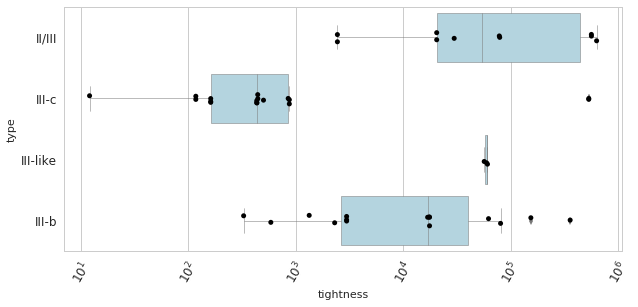

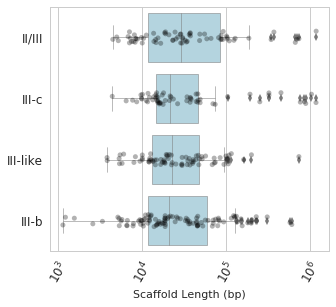

In [69]:
# subset types we want to plot
nsp_sub = nsp_final[(nsp_final.tightness != "n/a") & (nsp_final.type != "unknown")]
nsp_sub2 = nsp_sub[(nsp_sub.tightness < 1000000)]
# do some re-arrangment
x = list(nsp_sub2["tightness"])
y = list(nsp_sub2["type"])
xy = pd.DataFrame(x,y)
xy["y"] = xy.index
xy.columns = ["x","y"]

# plot tightness by type 
plt.figure(figsize=(10,4.5))
g = sns.boxplot(x="x", y= "y",data=xy,color="lightblue", linewidth=0.5)#, ax=axs[0])
sns.stripplot(x="tightness", y="type", data=nsp_sub2, jitter=True, color="black")#, ax=axs[0])
plt.xticks(rotation=60, ha="center", fontsize=12)
plt.yticks(fontsize=12)
g.set(xscale="log")
plt.savefig(os.path.join(working_directory + "/images/fig_3a.svg"), format="svg")

# read in internal contig lengths
int_scaf_df = pd.read_table(os.path.join(working_directory + "/data/scaffold_info/ggk_contigsize.txt"), header=None)
# read in external contig lengths
ext_scaf_df = pd.read_table(os.path.join(working_directory + "/data/scaffold_info/all_external_scaffold.info"), header=None)
# and concatenate
scaf_df = pd.concat([int_scaf_df, ext_scaf_df], axis=0)
scaf_df.columns = ["gene_scaffold", "scaffold_len"]
# merge with df
nsp_final["gene_scaffold"] = nsp_final["gene"].apply(lambda x: scaffold(x))
nsp_x = nsp_final[nsp_final.type.isin(list(set(nsp_sub2["type"])))][["bin", "gene", "final_tax", "type", "gene_scaffold"]]
nsp_x2 = pd.merge(nsp_x, scaf_df, on="gene_scaffold", how="left")

# now plot scaffold length by type 
plt.figure(figsize=(5,4.5))
p = sns.boxplot(x="scaffold_len", y= "type",data=nsp_x2, orient="b", color="lightblue", order=["II/III", "III-c", "III-like","III-b"], linewidth=0.5)#, ax=axs[1])
sns.stripplot(x="scaffold_len", y="type", data=nsp_x2, jitter=True, color="black", alpha=0.3, order=["II/III", "III-c", "III-like","III-b"])
plt.xlabel("Scaffold Length (bp)")
plt.ylabel("")
p.set(xscale="log")
plt.xticks(rotation=60, ha="center", fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(working_directory + "/images/figure_3b.svg"), format="svg")

This plot show us that Form III-c rubisco types have more AMP pathways on a single contig, and that those pathways are generally are closer together (save for a few bizarre external genomes). However, all genomes with AMP pathway had similar median assembled contig lengths.

### investigating rubisco fusions - Figure S3

We also want to examine cases where RuBisCO is fused to one of the other AMP pathway components. Candidate fusion genes were identified based on protein length and subsequently verfied with NCBI blastp.

In [70]:
fusions = [row.strip() for row in open(os.path.join(working_directory + "/data/candidate_fusions.names"))]
data3[data3["gene"].isin(fusions)][["bin","gene", "final_tax", "type"]]

,bin,gene,final_tax,type
117,MOL_16ft_UNK,mol-32-1605-030446_1_Gottesmanbacteria,Gottesmanbacteria,III-c
126,CG22_combo_CG10-13_8_21_14_all_Parcubacteria_3...,CG22_combo_CG10-13_8_21_14_all_scaffold_27032_...,Parcubacteria,III-c
273,GWC2_OP11_39_8_plus,gwc2_scaffold_9210_4,Gottesmanbacteria,III-c
555,external Microgenomates bacterium JGI CrystG A...,img_2698597071_3,Microgenomates,III-c


In [71]:
# if not in data3...
nsp_final[nsp_final["gene"].isin(fusions)][["bin","gene", "final_tax", "type"]]

,bin,gene,final_tax,type
32,GWA2_OP11_41_12,gwa2_scaffold_5171_26,Gottesmanbacteria,III-c
36,GWC2_OP11_39_8_plus,gwc2_scaffold_9210_4,Gottesmanbacteria,III-c
345,external Microgenomates bacterium JGI CrystG A...,img_2698597071_3,Microgenomates,III-c


We can visualize these genes in comparison to those from other types in the following plot...

In [72]:
# make graph of rubisco lengths by tax/type
# read in sequences and calculate lengths
lengths = {}
for record in SeqIO.parse(open(os.path.join(working_directory + "/data/rubisco_final.drep99.wrefs.faa")),"fasta"):
    # retrieve genes names from seq header
    desc = re.search("(\S+).*", record.description).group(1)
    lengths[desc] = len(record.seq)
len_df = pd.DataFrame.from_dict(lengths, orient="index")
len_df = len_df.reset_index()
len_df.columns = ["gene", "gene_length"]
len_info = pd.merge(final, len_df, on="gene").fillna("None")
len_info_sub = len_info[~len_info.type.isin(["II", "unknown"])]

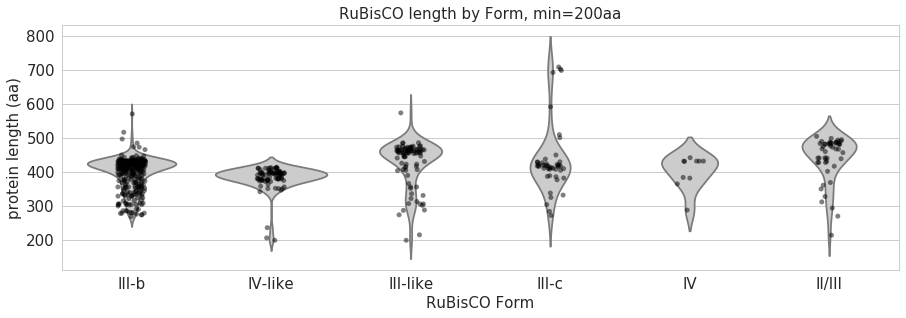

In [73]:
plt.figure(figsize=(15,4.5))
sns.violinplot(x="type", y="gene_length", data=len_info_sub,inner=None, color=".8")
sns.stripplot(x="type", y="gene_length", data=len_info_sub, jitter=True, color="black", alpha=0.5)
plt.title("RuBisCO length by Form, min=200aa", size=15)
plt.xlabel("RuBisCO Form", size=15)
plt.ylabel("protein length (aa)", size=15)
plt.tick_params(labelsize=15)
plt.savefig(os.path.join(working_directory + "/images/fig_s3.svg"), format="svg")

# PRK/CBB analysis

<ul>
    1.    [Main RuBisCO analysis](#main-rubisco-analysis)<br>
    2.    [AMP Pathway analysis](#AMP-pathway-analysis)<br>
    3.    [PRK/Calvin Cycle analysis](#PRK/CBB-analysis)
</ul>

Next, we analyzed the presence of PRK and other CBB cycle components in the binned genomes. To do this, we first need to extract hits to the enzymes in question from the KEGG HMM analysis.

#### generate data

In [74]:
# define list of enzymes and kegg orthology numbers
orthologies = {
    "02_Cal_phosphoglycerate_kinase":["K00927"],
    "03_Cal_GAP-DH": ["K00134","K05298","K00150"],
    "04_Cal_TIM": ["K01803"],
    "05_Cal_fructose-bisphosphate_aldolase": ["K01622", "K01623","K01624","K11645","K16305","K16306"],
    "06_Cal_fructose-bisphosphatase": ["K01086", "K01622", "K02446", "K03841", "K04041", "K11532"],
    "07_Cal_Transketolase": ["K00615"],
    "08_Cal_Sedoheptulose-bisphosphatase": ["K01086", "K01100", "K11532"],
    "09_Cal_Ribose-5-phosphate_isomerase": ["K01807", "K01808"],
    "10_Cal_Ribulose-phosphate_3-epimerase": ["K01783"],
    "11_Cal_Phosphoribulokinase": ["K00855"],
}

In [75]:
os.mkdir(os.path.join(working_directory + "/data/kegg_analysis/cbb_results/"))

In [76]:
# generate results files
for step in orthologies:
    for orthology in orthologies[step]:
        call = "grep -w " + orthology + " " + working_directory + "/data/kegg_analysis/all_proteins.keggHMM.report.tab | cut -f2,3 >> " + working_directory + "/data/kegg_analysis/cbb_results/" + step + ".results"
        sp.call(call, shell=True)

In [77]:
# now read these results into a df
base = binned3
path_nos = []

for file in glob.glob(working_directory + "/data/kegg_analysis/cbb_results/*"):

    path_no = os.path.basename(file).split("_")[0]
    path_nos.append(path_no)
    
    temp = []
    for line in open(file).readlines():
        temp.append({"bin2":line.split("\t")[0].strip(), "gene":line.split("\t")[1].strip()})
    # turn into dict
    temp_df = pd.DataFrame.from_dict(temp)
    temp_df.columns = ["bin2", path_no]
    # iteratively join with base
    base = pd.merge(base, temp_df, how="left", on="bin2").fillna("None").drop_duplicates()

# reorder cols
cols = list(base.columns[0:11]) + sorted(path_nos)
base = base[cols]

Now we have a dataframe attaching KEGG HMM hits to genome information. Next, we calculate CBB gene count...

In [78]:
def is_complete(row):
    
    count=1
    
    for step in path_nos:
        if row[step] != "None":
            count+=1
    return count

def scaffoldize(row):
    
    scaffolds = []
    for gene in genes:
        
        if row[gene] != "None":
            scaffolds.append(re.search("(.+?)_[0-9]+$", row[gene]).group(1))
        else:
            continue
    
    # this gives the number of genes on same scaf
    return  len(set(scaffolds))   

In [79]:
# apply functions
base["gene_count"] = base.apply(is_complete, axis=1)
genes = ["gene"] + path_nos
base["nscaf"] = base.apply(scaffoldize, axis=1)

Interesting genomes will have a high number of genes involved in CBB on the fewest number of scaffolds.

In [80]:
top = base[(base.nscaf < 7) & (base.gene_count >= 10) & (base["11"]!="None")][["nscaf", 'final_tax', "type","gene_count", "bin","gene"] +cols[11:]]
top

,nscaf,final_tax,type,gene_count,bin,gene,02,03,04,05,06,07,08,09,10,11
334,6,Microgenomates,III-like,10,OP11_GWA2_43_14,gwa2_scaffold_134_63,gwa2_scaffold_51_32,gwa2_scaffold_51_31,gwa2_scaffold_87_168,gwa2_scaffold_51_27,gwa2_scaffold_51_27,gwa2_scaffold_711_5,None,gwa2_scaffold_2703_6,gwa2_scaffold_711_4,gwa2_scaffold_760_5
345,6,Peregrinibacteria,II/III,10,PER_GWF2_39_17,gwf2_scaffold_2732_6,gwf2_scaffold_913_43,gwf2_scaffold_174_98,gwf2_scaffold_2411_19,gwf2_scaffold_174_99,None,gwf2_scaffold_207_61,gwf2_scaffold_174_97,gwf2_scaffold_207_58,gwf2_scaffold_207_57,gwf2_scaffold_1133_21
530,6,Gottesmanbacteria,III-like,10,Candidatus Gottesmanbacteria bacterium RIFCSPH...,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...,None,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...,RIFCSPHIGHO2_01_FULL_OP11_42_27_rifcsphigho2_0...
543,6,Gottesmanbacteria,III-like,10,Candidatus Gottesmanbacteria bacterium RIFCSPH...,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...,None,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...,RIFCSPHIGHO2_12_FULL_OP11_40_13_rifcsphigho2_1...
548,6,Gottesmanbacteria,III-like,10,Candidatus Gottesmanbacteria bacterium RIFCSPL...,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...,None,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...,RIFCSPLOWO2_01_FULL_OP11_42_22_rifcsplowo2_01_...
555,6,Gottesmanbacteria,II/III,10,Candidatus Gottesmanbacteria bacterium RIFCSPL...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,None,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...
556,6,Gottesmanbacteria,II/III,10,Candidatus Gottesmanbacteria bacterium RIFCSPL...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,None,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...
559,6,Gottesmanbacteria,III-like,10,Candidatus Gottesmanbacteria bacterium RIFCSPL...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,RIFCSPLOWO2_02_FULL_OP11_38_8_rifcsplowo2_02_s...,None,RIFCSPLOWO2_0

From here we can pick a few exemplary genomes to model for a figure.

In [ ]:
exemplar_genomes = ["PER_GWF2_39_17", "Candidatus Gottesmanbacteria bacterium RIFCSPHIGHO2_12_FULL_40_13", 'Candidatus Gottesmanbacteria bacterium RIFCSPLOWO2_02_FULL_38_8', "CG_4_10_14_0_2_um_filter_CG_Gottesman_01_37_9__abawaca.347"]
fig_top = top[top.bin.isin(exemplar_genomes)]

# rename genomes for figure
def rename(row):
    
    return row["final_tax"] + " (type " + row['type'] + " RuBisCO)"

fig_top['new_name'] = fig_top.apply(rename, axis=1)

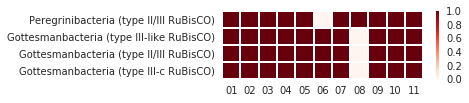

In [82]:
# figure version
basef = fig_top.set_index("new_name")

# reformat enzyme names
enzyme_names = {}
for item in orthologies:
    enzyme_names[item.split("_")[0]] = item.split("_")[0] #+ " - " + " ".join(item.split("_")[2:])
    
# now plot
basef2 = basef[["gene"] +cols[11:]]
basef2.columns = ["01"] + [enzyme_names[col] for col in cols[11:]]
basef3 = basef2 != "None"
basef3["bin"] = basef3.index
basef4 = basef3.drop_duplicates()
basef5 = basef4.drop("bin", axis=1)
plt.figure(figsize=(4.5,1.25))
sns.heatmap(basef5, annot=False, fmt=".0f", linewidths=1, cmap="Reds")
plt.xticks(rotation=0, ha="center")
plt.ylabel('')
plt.savefig(os.path.join(working_directory + "/images/fig_4.svg"), format="svg")

Looking at the above dataframe, can also see here that enzymes 5 and 6 (FBA/FBPase) are identical for many genomes - see discussion of bifunctional enzyme in Results/Discussion. 

### exploring genomes with the bifunctional FBA/FBPase

In [83]:
# separate out genomes with bifunctional versions and different versions
diff = base[(base.final_tax=="Gottesmanbacteria") & (base["05"] != base["06"])]
same = base[(base.final_tax=="Gottesmanbacteria") & (base["05"] == base["06"])]

In [84]:
# how many bins have the bifunctional copy?
print(len(set(same["bin"])))

37


In [85]:
# how many bins have different versions?
print(len(set(diff["bin"])))

13


Most Gottesmanbacteria appear to encode the bifunctional FBPase/FBA.

In [86]:
# which possibly have both?
both = list(set(diff["bin"]).intersection(set(same["bin"])))
print(both)

['CG_4_10_14_0_2_um_filter_CG_Gottesman_01_37_9__abawaca.347', 'CG_4_8_14_3_um_filter_Gottesmanbacteria_36_8', 'CG22_combo_CG10-13_8_21_14_all_CG_Gottesman_01_36_6__abawaca.154']


In [87]:
# three genomes with bifunctional
base[base.bin.isin(both)][["bin","05","06"]].drop_duplicates()

,bin,05,06
619,CG22_combo_CG10-13_8_21_14_all_CG_Gottesman_01...,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_6,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_6
620,CG22_combo_CG10-13_8_21_14_all_CG_Gottesman_01...,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_6,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_7
621,CG22_combo_CG10-13_8_21_14_all_CG_Gottesman_01...,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_7,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_6
622,CG22_combo_CG10-13_8_21_14_all_CG_Gottesman_01...,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_7,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_7
623,CG22_combo_CG10-13_8_21_14_all_CG_Gottesman_01...,CG22_combo_CG10-13_8_21_14_all_scaffold_11415_1,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_6
624,CG22_combo_CG10-13_8_21_14_all_CG_Gottesman_01...,CG22_combo_CG10-13_8_21_14_all_scaffold_11415_1,CG22_combo_CG10-13_8_21_14_all_scaffold_6433_7
639,CG_4_10_14_0_2_um_filter_CG_Gottesman_01_37_9_...,CG_4_10_14_0.2_scaffold_3101_3,CG_4_10_14_0.2_scaffold_3101_3
641,CG_4_10_14_0_2_um_filter_CG_Gottesman_01_37_9_...,CG_4_10_14_0.2_scaffold_13977_1,CG_4_10_14_0.2_scaffold_3101_3
643,CG_4_8_14_3_um_filter_Gottesmanbacteria_36_8,Crystal_Geyser_4_8_14_3_um_filter_scaffold_5517_5,Crystal_Geyser_4_8_14_3_um_filter_scaffold_5517_5
646,CG_4_8_14_3_um_filter_Gottesmanbacteria_36_8,Crystal_Geyser_4_8_14_3_um_filter_scaffold_5517_5,Crystal_Geyser_4_8_14_3_um_filter_scaffold_826...


These three genomes encode the bi-functional enzyme but also separate FBA or FBPase.

In [88]:
# those with same, what rubisco types?
same[["bin","type"]].drop_duplicates()["type"].value_counts()

III-like    19
III-c       18
II/III       1
Name: type, dtype: int64

### PRK

In [89]:
#number of genomes with PRK
len(set(base[base["11"]!="None"]["bin"]))

31

In [90]:
# get rid of duplicate bins
test = base[["bin", "type", "final_tax", "11"]].drop_duplicates()
test[test["11"] != "None"].groupby(["type", "final_tax"]).size()

type      final_tax        
II/III    Gottesmanbacteria     1
          Peregrinibacteria     2
III-c     Gottesmanbacteria    11
          Parcubacteria         1
III-like  Gottesmanbacteria    16
          Microgenomates        1
dtype: int64

Most of our genomes that have both RuBisCO and a "true" PRK are Microgenomates with a Form III-like or Form III-c. This is an interesting linkage. N.B. One Gottesmanbacteria genome has two RuBisCO genes, thus the sum above. 